In [2]:
# Load Neccessary Libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import caffe

In [3]:
# Load caffe model
caffe.set_mode_cpu()

net = caffe.Net('./model/lenet.prototxt',
                './model/lenet_iter_50000.caffemodel',
               caffe.TEST)


In [4]:
# Swap 2 objects
def swap(a,b):
    return b,a

'''
Sort a four-point arrary with respect to its relative spatial location

Output: [pt1, pt2, pt3, pt4]
Satifying the following spatial condition: |pt1 pt2|
                                           |pt3 pt4|
'''
def sort_points(rect):
    x_sort = np.array(sorted(rect, key=lambda x: x[1]))
    if x_sort[0,0] > x_sort[1,0]:
        x_sort[0,0], x_sort[1,0] = swap(x_sort[0,0], x_sort[1,0])
    if x_sort[2,0] > x_sort[3,0]:
        x_sort[2,0], x_sort[3,0] = swap(x_sort[2,0], x_sort[3,0])  
    return x_sort

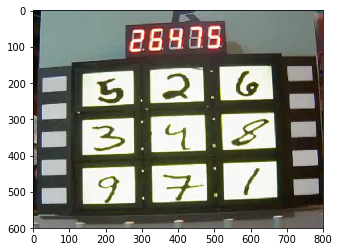

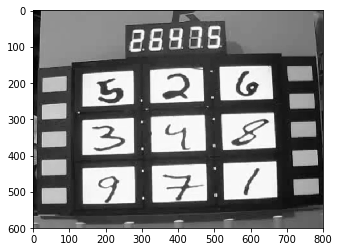

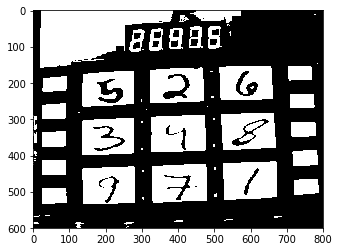

In [5]:
# Load image and compute its threshold binary map
img = cv2.imread('./testimg.JPG')
img = cv2.resize(img, (800,600))
img_cp = img.copy()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret3,thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

plt.imshow(cv2.cvtColor(img_cp, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(gray, cmap='gray')
plt.show()
plt.imshow(thresh, cmap='gray')
plt.show()

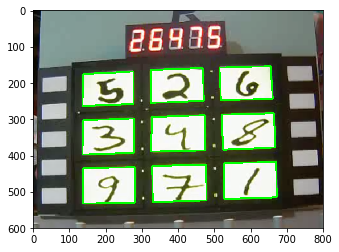

In [6]:
# Find all contours
im2, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
# Filter out contours that are either too big or too small
contours = [cnt for cnt in contours if cv2.contourArea(cnt) >= 100*50 and cv2.contourArea(cnt) <= 180*90]
# Find contour approximation and enforce a 4-sided convex shape
tmp = []
for cnt in contours:
    epsilon = 0.05*cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt,epsilon,True)
    if len(approx) == 4 and cv2.isContourConvex(approx):
        tmp.append(approx)
contours = np.array(tmp)[:,:,0,:]
cv2.drawContours(img, contours, -1, (0,255,0), 3)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

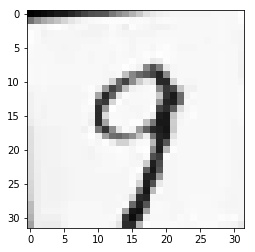

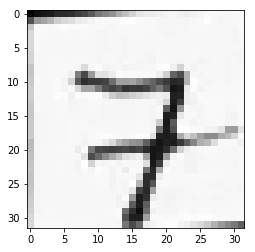

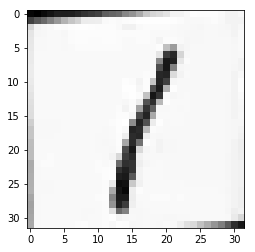

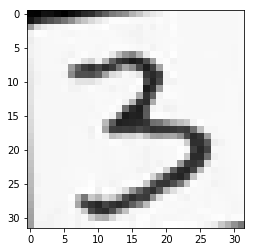

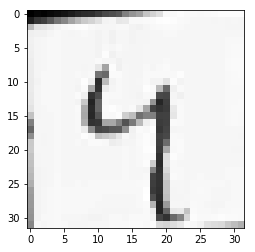

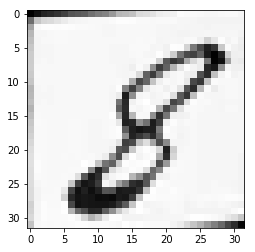

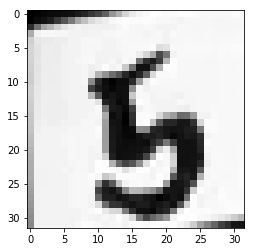

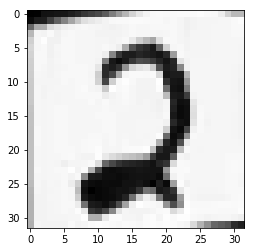

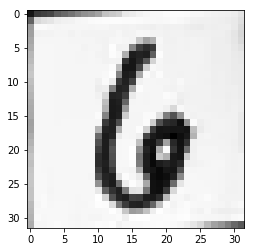

In [7]:
BOX_LEN = 32                # bounding box length for digits
offset = (BOX_LEN - 28) / 2 # calculated padding length
# Destination Points
dstpts = np.array([[0,0],[BOX_LEN,0],[0,BOX_LEN],[BOX_LEN,BOX_LEN]], dtype='float32')

bboxs = []
points = []

for cnt in contours:
    # Sort points with respect to relative location
    pts1 = sort_points(cnt).astype('float32')
    points.append(pts1)
    # Geometric transformation that project the 4-sided shape onto a 32x32 grid
    M = cv2.getPerspectiveTransform(pts1,dstpts)
    new_img = cv2.warpPerspective(gray,M,(BOX_LEN,BOX_LEN))
    #new_img = 255 - new_img[offset:-offset, offset:-offset]
    bboxs.append(new_img)
    plt.imshow(bboxs[-1], cmap='gray')
    plt.show()

bboxs = np.array(bboxs)[:, None,...]

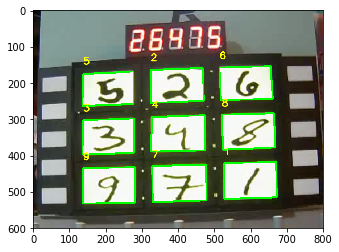

In [7]:
net.blobs['data'].reshape(bboxs.shape[0], 1, 28, 28)
net.blobs['data'].data[...] = bboxs.astype('float32') / 255
out = net.forward()
dig_ids = out['prob'].argmax(axis = 1)
for i in range(len(points)):
    cv2.putText(img, str(dig_ids[i]),
                (int(points[i][0,0]), int(points[i][0,1]-20)),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.9,
               (0,255,255),
               2,cv2.LINE_AA)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

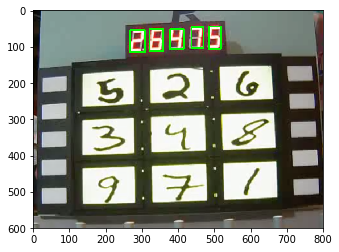

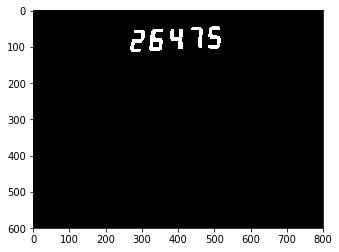

In [11]:
org_img = img_cp.copy()
hsv_img = cv2.cvtColor(org_img, cv2.COLOR_BGR2HSV)
lower_red = np.array([0,4,210])
upper_red = np.array([25,255,255])
mask = cv2.inRange(hsv_img, lower_red, upper_red)
mask1 = cv2.inRange(hsv_img, lower_red, upper_red)
lower_red = np.array([155,4,210])
upper_red = np.array([179,255,255])
mask2 = cv2.inRange(hsv_img, lower_red, upper_red)
mask = np.bitwise_or(mask1, mask2)

kernel1 = np.ones((9,9),np.uint8)
kernel2 = np.ones((6,6),np.uint8)
kernel3 = np.ones((3,3),np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel1)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel2)

y_min = min(contours,key=lambda cnt: cnt[0,1])[0,1]
y_min = int(y_min)
ftr = np.ones((600,800),np.uint8)
ftr[y_min:-1,:] = 0
mask = cv2.bitwise_and(mask, mask, mask=ftr)

im2, sct_cnts, hierarchy = cv2.findContours(mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
rects = [cv2.boundingRect(cnt) for cnt in sct_cnts]
rects = sorted(rects, key=lambda x: x[0])

for rect in rects:
    cv2.rectangle(org_img, (rect[0], rect[1]),(rect[0]+rect[2], rect[1]+rect[3]),(0,255,0),3)

#mask = cv2.dilate(mask, kernel3)
res = cv2.bitwise_and(gray, gray, mask=mask)
plt.imshow(cv2.cvtColor(org_img, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(mask, cmap='gray')
plt.show()

In [25]:
def pad_diggit(img):
    w, h = img.shape[1], img.shape[0]
    length = int(h * 1.4)
    v_pad = int((length - h) / 2)
    h_pad = int((length - w) / 2)
    new_img = cv2.copyMakeBorder(img, v_pad, v_pad, h_pad, h_pad, borderType=cv2.BORDER_CONSTANT, value=0)
    #new_img = cv2.resize(new_img, (8, 8))
    return cv2.resize(new_img, (28,28))

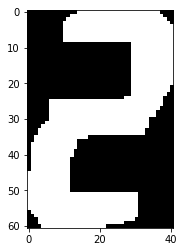

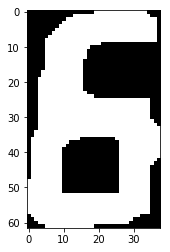

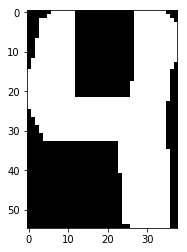

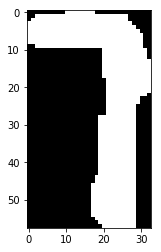

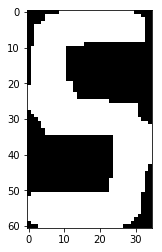

In [30]:
for rect in rects:
    x, y, w, h = rect[0], rect[1], rect[2], rect[3]
    crop = mask[y:y+h, x:x+w]
    plt.imshow(crop, cmap='gray')
    plt.show()

In [29]:
secrets = np.array([pad_diggit(mask[rect[1]:rect[1]+rect[3],rect[0]:rect[0]+rect[2]]) for rect in rects], dtype='float32')
secrets = secrets[:,None,...].astype('float32') / 255
net.blobs['data'].reshape(secrets.shape[0], 1, 28, 28)
net.blobs['data'].data[...] = secrets
out = net.forward()
dig_ids = out['prob'].argmax(axis = 1)
print out['prob']

[[  1.71885978e-10   9.06149637e-07   9.95879292e-01   2.95807864e-03
    2.47006943e-10   2.65742406e-09   4.79492357e-09   1.19749413e-04
    1.04182819e-03   3.35884237e-10]
 [  1.21147752e-06   7.49971747e-08   5.01189731e-07   4.88133001e-09
    4.98802200e-09   9.88522887e-01   2.71932082e-03   1.15441057e-09
    8.75561405e-03   4.55456700e-07]
 [  6.58419784e-14   2.22624801e-11   2.72447776e-12   4.14158072e-15
    9.99999762e-01   1.81947534e-16   7.69446681e-13   2.67640154e-09
    2.80942658e-10   2.69899886e-07]
 [  2.27091138e-10   1.67304142e-06   1.76311630e-06   9.52973949e-07
    4.13010663e-13   7.20445315e-10   3.80168038e-15   9.99707878e-01
    2.14199822e-08   2.87732866e-04]
 [  1.93270599e-15   3.13896392e-12   1.28586949e-15   4.37160828e-11
    1.06475582e-14   9.99997020e-01   1.20019511e-12   1.93709045e-15
    2.86508745e-13   2.95034238e-06]]
